# Homework 5
#### Yufeng Yuan
#### yy208@duke.edu

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from copy import deepcopy
import os
import skimage.filters as filters
from time import gmtime, strftime, sleep
from PIL import ImageFilter
from scipy import interpolate as interp
from skimage.restoration import denoise_tv_chambolle
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [7]:
def move_focus(sid=1, step=0):
    cmD='rsh ubuntu@10.0.1.7 "sudo python2 ~/Desktop/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    #return pop.stdout

def take_photos(sid=1, step=0, iters=1, start=0):
    subprocess.run('rm dbGrab*', \
               stdout=subprocess.PIPE, shell=True)
    subprocess.run('rsh ubuntu@10.0.1.7 "rm dbGrab*"', \
               stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.7 "sudo python2 ~/Desktop/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    for i in range(iters):
        subprocess.run('rsh ubuntu@10.0.1.7 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                --file-name dbGrab_'+str(i*step)+' --image-res 8"', stdout=subprocess.PIPE, shell=True)
        #cmD='rsh ubuntu@10.0.1.7 "sudo python2 ~/Desktop/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp ubuntu@10.0.1.7:dbGrab* .', \
                stdout=subprocess.PIPE, shell=True)
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    return pop

def read_eval(x=0, y=0, h=2160, w=3840):
    names = os.listdir()
    pics = []
    scores = []
    for name in sorted(names):
        if name[:6] == 'dbGrab':
            pic = imio.imread(name)
            pics.append(pic)
            scores.append(np.sum(filters.sobel(pic[x:x+w, y:y+h,0])))
    ind = scores.index(max(scores))
    #imio.imshow(pics[ind])
    focus = 100 * ind
    return focus, pics[ind], scores

def auto_focus(sid=1, region=[0,0,2160,3840]):
    take_photos(sid, 100, 10)
    x, y, h, w = region
    focus, pics, scores = read_eval(x, y, h, w)
    start = -1500
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(focus+100)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    pop = take_photos(sid, 0, 1, 0)
    imio.imshow(pop)
    return focus, pop, scores

def grabImage(sid=1, imres=8, fm=1, cameraNumber=7, iters=1):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    for i in range(iters):
        print(i)
        cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                       stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                       stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        pop=pop[250416:]
        pop=np.reshape(pop,(2174,3864))
       # pop=np.append(pop[:,2060:] ,pop[:,:2060],axis=1)
    return pop

def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI

def demosaic(raw):
    # weird here, for the 1780 boundary, there are differnt color sensor for these two regions
    raw_left, raw_right = raw[:, :744], raw[:, 744:]
    red_left = raw_left[::2, ::2]
    green_left = raw_left[1::2, 0::2]
    blue_left = raw_left[1::2, 1::2]
    red_right = raw_right[1::2, 0::2]
    green_right = raw_right[1::2, 1::2]
    blue_right = raw_right[0::2, 1::2]
    
    red = np.append(red_left, red_right, axis=1)
    green = np.append(green_left, green_right, axis=1)
    blue = np.append(blue_left, blue_right, axis=1)
    jpg_image = np.dstack((red, green, blue))
    jpg_image = 800 * np.log(jpg_image) / np.max(np.log(jpg_image)) - 550
    jpg_image = jpg_image.astype(np.uint8)
    jpg_image = np.repeat(np.repeat(jpg_image, 2, axis=1), 2, axis=0)
    return jpg_image

def RawPixelSamples(sid=1, imres=8, cameraNumber=7, frames=100, samplePixels=10000):
    # I will use the file name dbGrab.... for the imae grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    pixels=np.random.randint(250416,2160*3840,samplePixels)
#    subprocess.run('rm dbGrab*', \
#                   stdout=subprocess.PIPE, shell=True)
#    subprocess.run('rm *raw', \
#                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab some images on the tegra
    #cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto -C '+str(frames)+' --dump-bayer\
    #--capture-gap 500 --image-res '+ str(imres)+'"'
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto -C 100 --dump-bayer\
    --capture-gap 500 --image-res '+ str(imres)+'"'
    for i in range(1):
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
        subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
        subprocess.run(cmdA+' "rm *.jpg"', \
                   stdout=subprocess.PIPE, shell=True)
        subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.findall(r'(.*).raw', rePop)
    pop=np.fromfile(fileName[0]+'.raw',dtype=np.dtype('i2'))
    pixelValues=pop[pixels]
    for index in range(1,len(fileName)):
        pop=np.fromfile(fileName[index]+'.raw',dtype=np.dtype('i2'))
        pixelValues=np.vstack((pixelValues,pop[pixels]))
                              
    return pixelValues

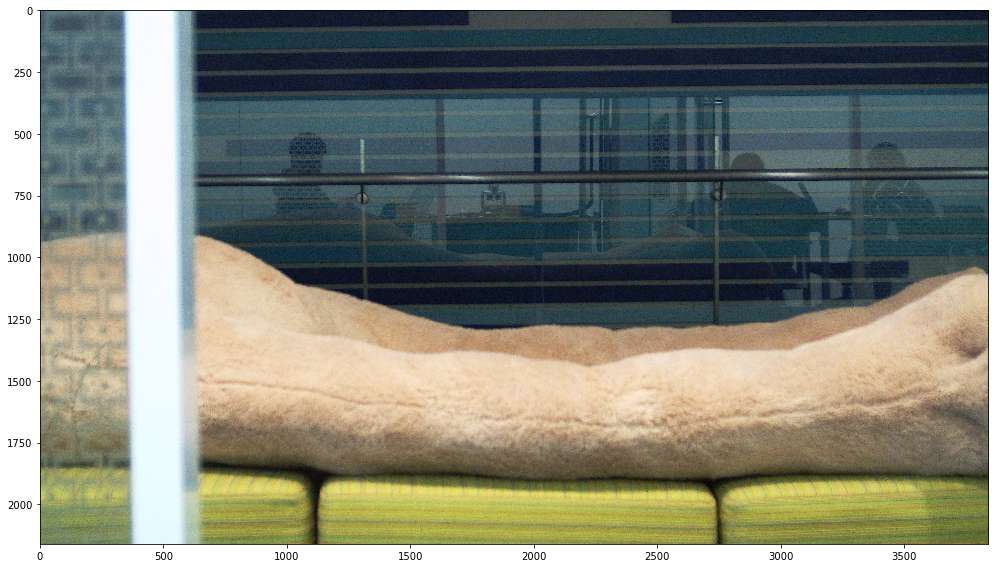

In [21]:
# Task 2
a = grabImage(fm=1, cameraNumber=7)
imio.imshow(a)

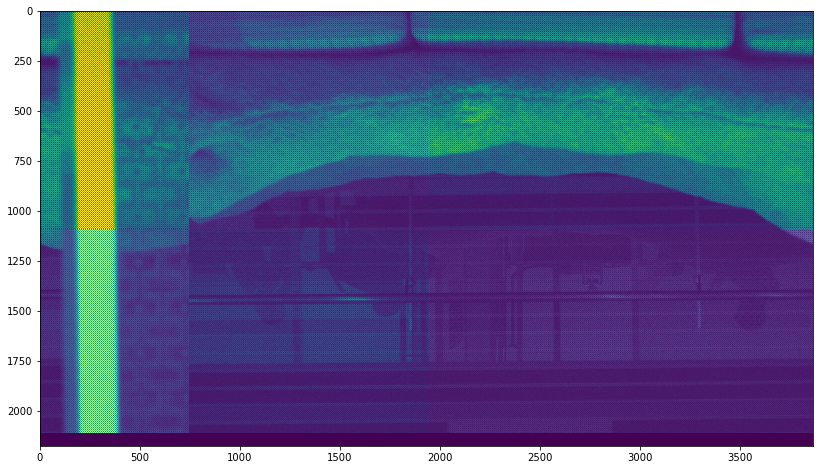

In [22]:
raw = grabImage(fm=2, cameraNumber=7)
#raw = demosaic(raw)
plt.imshow(raw)

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log


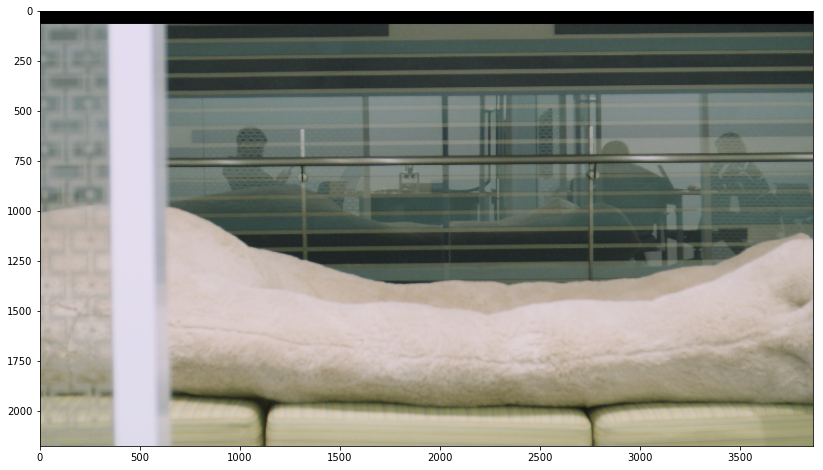

In [24]:
tmp = demosaic(raw)
jpg = deepcopy(tmp)
jpg[:, 3120:] = tmp[:, :744]
jpg[:, :3120] = tmp[:, 744:]
jpg = trans.rotate(jpg, 180)
jpg = adjustColor(jpg, 1.1, 1.6, 0.9, 3, 0.8)
jpg = denoise_tv_chambolle(jpg, n_iter_max=20, multichannel=True)
edge = filters.sobel(jpg[:, :, 0])
jpg[:, :, 0] += edge
edge = filters.sobel(jpg[:, :, 1])
jpg[:, :, 1] += edge
edge = filters.sobel(jpg[:, :, 2])
jpg[:, :, 2] += edge
plt.imshow(jpg)

In [8]:
# Task 3
pixelValues = RawPixelSamples(sid=2)

In [9]:
pixelMean=np.mean(pixelValues,axis=0)
pixelStd=np.std(pixelValues,axis=0)

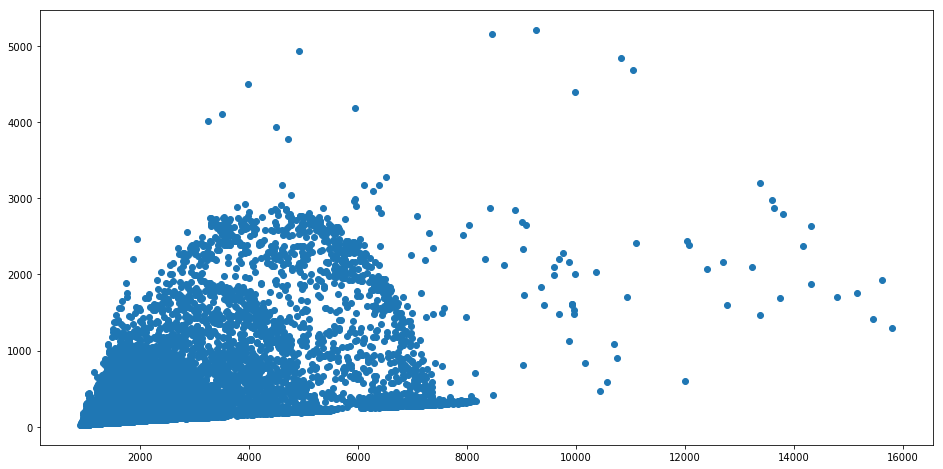

In [10]:
plt.scatter(pixelMean,pixelStd)

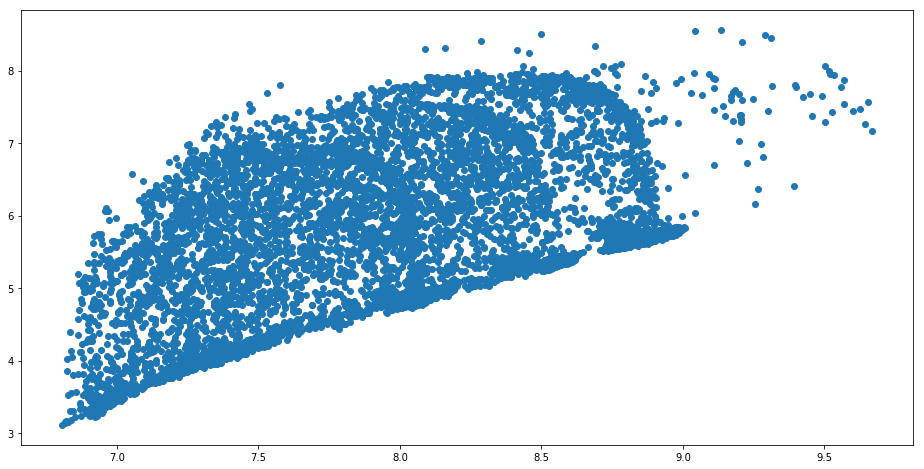

In [11]:
plt.scatter(np.log(pixelMean),np.log(pixelStd))